# PhaseNet demo

Zhu, W. and Beroza, G.C., 2019. PhaseNet: a deep-neural-network-based seismic arrival-time picking method. Geophysical Journal International, 216(1), pp.261-273.

This is largely based on the demo jupyter notebooks provided on github: https://github.com/wayneweiqiang/PhaseNet

1. Download, prepare and plot sample data
2. Picking a single event in a waveform slice
3. Picking multiple events in a day file, and across multiple stations
4. Training a model?

In [1]:
# Imports 
import os
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core import read
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pickle
import pandas as pd


## 1. Download data using obspy

This notebook uses some data from the IGUANA temporary seismic network deployed on Sierra Negra. Details about the installation can be found here: http://www.fdsn.org/networks/detail/8G_2018/


In [2]:
pwd

'/Volumes/sbutcher/ML in Seismology/PhaseNet_Tutorial/PhaseNet/demo'

In [3]:
starttime = UTCDateTime("2018-06-04T00:00:00")
endtime = UTCDateTime("2018-06-05T00:00:00")

First time, run to download the data:

In [4]:
client = Client("IRIS")
data_dir = "./mseed"

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
stations = ["SN07", "SN14"]
fdsn_code = "8G"

In [5]:
st_store = []

for station in stations: 
    if os.path.exists(data_dir+"/"+str(station)+".mseed") == True:
        print(station, "mseed file exists")
        st = read(data_dir+"/"+str(station)+".mseed")
        st_store.append(st)
    else:
        st = client.get_waveforms(fdsn_code, station, "*", "*", starttime, endtime)
        st.write(data_dir+"/"+str(station)+".mseed")
        print(station, "file written")
        print(st)
        st_store.append(st)

SN07 mseed file exists
SN14 mseed file exists


The time window selected is 4th June 2018, approximately 2 weeks prior to the onset of eruption at Sierra Negra. We can see there are several large earthquakes throughout the day, as well as a number of smaller events. 

In [6]:
st_store

[3 Trace(s) in Stream:
8G.SN07..HHE | 2018-06-04T00:00:00.000000Z - 2018-06-05T00:00:00.000000Z | 100.0 Hz, 8640001 samples
8G.SN07..HHN | 2018-06-04T00:00:00.000000Z - 2018-06-05T00:00:00.000000Z | 100.0 Hz, 8640001 samples
8G.SN07..HHZ | 2018-06-04T00:00:00.000000Z - 2018-06-05T00:00:00.000000Z | 100.0 Hz, 8640001 samples,
 3 Trace(s) in Stream:
8G.SN14..HHE | 2018-06-04T00:00:00.000000Z - 2018-06-05T00:00:00.000000Z | 100.0 Hz, 8640001 samples
8G.SN14..HHN | 2018-06-04T00:00:00.000000Z - 2018-06-05T00:00:00.000000Z | 100.0 Hz, 8640001 samples
8G.SN14..HHZ | 2018-06-04T00:00:00.000000Z - 2018-06-05T00:00:00.000000Z | 100.0 Hz, 8640001 samples]

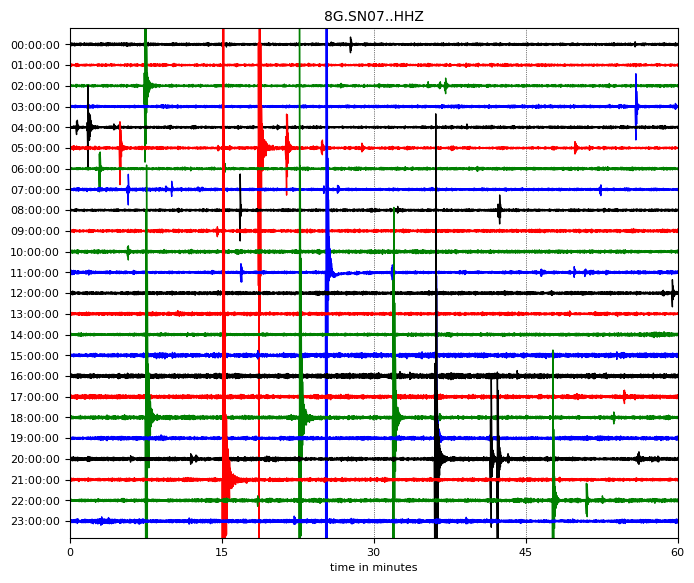

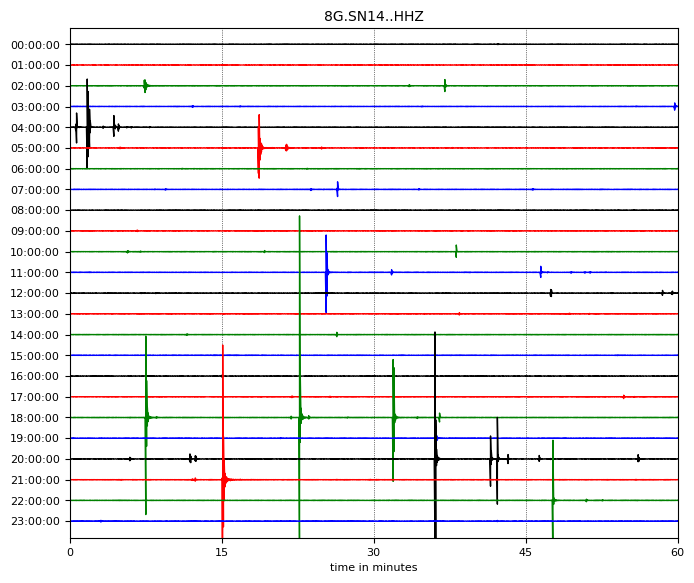

In [7]:
# plot day file for each station
for st in st_store:
    stz = st.select(component="Z")
    stz.plot(type="dayplot", interval=60, color=["k", "r", "g", "b"], one_tick_per_line=True, show_y_UTC_label=False, vertical_scaling_range=5e4)

## 2. Using QuakeFlow API

Initially we can just test PhaseNet on one single event and then one station before progressing. Let's look at the big earthquake we see at 05:18am

3 Trace(s) in Stream:
8G.SN07..HHE | 2018-06-04T05:18:30.000000Z - 2018-06-04T05:19:30.000000Z | 100.0 Hz, 6001 samples
8G.SN07..HHN | 2018-06-04T05:18:30.000000Z - 2018-06-04T05:19:30.000000Z | 100.0 Hz, 6001 samples
8G.SN07..HHZ | 2018-06-04T05:18:30.000000Z - 2018-06-04T05:19:30.000000Z | 100.0 Hz, 6001 samples


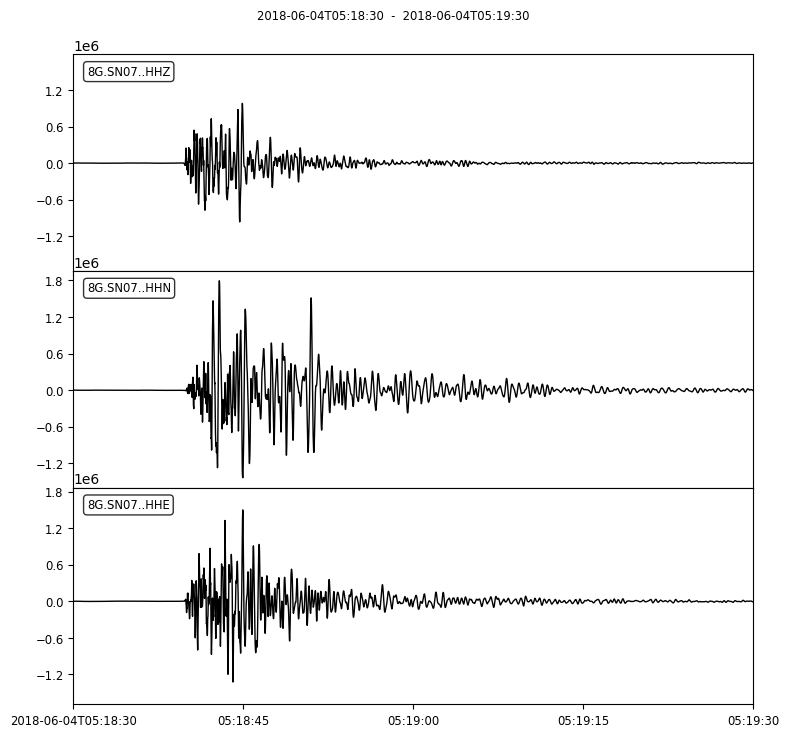

3 Trace(s) in Stream:
8G.SN14..HHE | 2018-06-04T05:18:30.000000Z - 2018-06-04T05:19:30.000000Z | 100.0 Hz, 6001 samples
8G.SN14..HHN | 2018-06-04T05:18:30.000000Z - 2018-06-04T05:19:30.000000Z | 100.0 Hz, 6001 samples
8G.SN14..HHZ | 2018-06-04T05:18:30.000000Z - 2018-06-04T05:19:30.000000Z | 100.0 Hz, 6001 samples


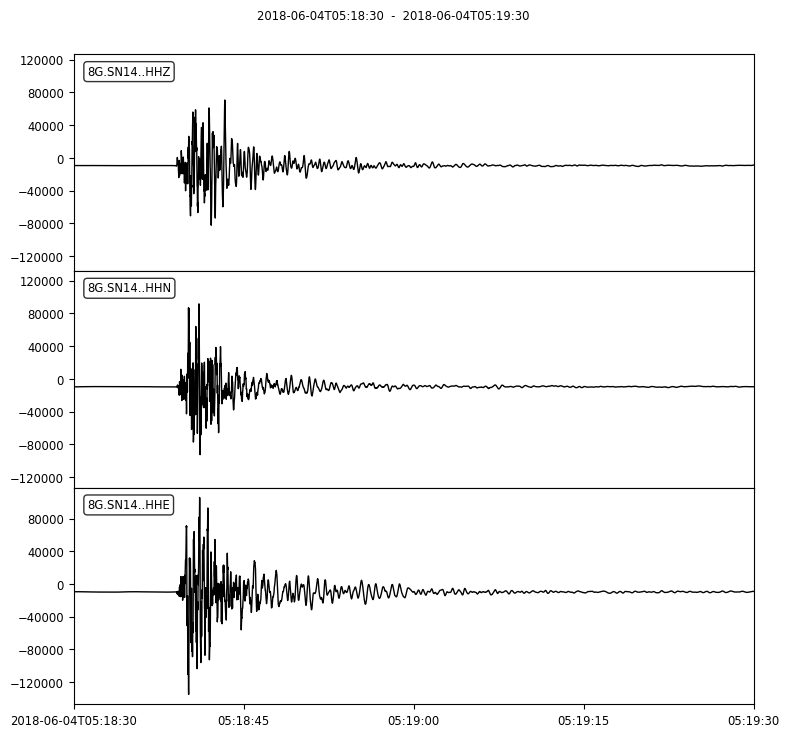

In [8]:
starttime = UTCDateTime("2018-06-04T05:18:30")
duration = 60
events = []
for st in st_store:
    stc = st.copy()
    event = stc.slice(starttime=starttime, endtime=starttime+duration)
    print(event)
    event.plot()
    events.append(event)

PhaseNet can be executed through the QuakeFlow API for small datasets and testing. Examples of this can be found under `/docs/example_interactive.ipynb`

In [ ]:
#!uvicorn --app-dir=../phasenet app:app --reload --port 8001

In [9]:
PHASENET_API_URL = "http://phasenet.quakeflow.com"
#PHASENET_API_URL = "http://127.0.0.1:8000"

In [15]:
# SN07 
stream = events[0].sort()

data = []
for trace in stream:
    data.append(trace.data)
data = np.array(data).T
assert(data.shape[-1] == 3)

data_id = stream[0].get_id()[:-1]
timestamp = stream[0].stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

print(data)
print(data_id)
print(timestamp)

[[ 1130  -403  1745]
 [ 1047  -858  1630]
 [ 1265  -703  1356]
 ...
 [-9099 -7523  2100]
 [-8351 -6900  2100]
 [-7026 -6078  1477]]
8G.SN07..HH
2018-06-04T05:18:30.000


You can just use the `predict` tool which will give you the pick time and the probability

In [14]:
req = {"id": [data_id],
       "timestamp": [timestamp],
       "vec": [data.tolist()]}

resp = requests.post(f'{PHASENET_API_URL}/predict', json=req)
#print('Picks', resp.json())
print(resp)
print(resp.json())

<Response [502]>


JSONDecodeError: Expecting value: line 2 column 1 (char 1)

Or if you use the `predict_prob` tool, it returns the timeseries in array format that we can plot with the input data 

In [13]:
resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
print(resp)
picks, preds = resp.json() 
preds = np.array(preds)
#print('Picks', picks)

<Response [502]>


JSONDecodeError: Expecting value: line 2 column 1 (char 1)

NameError: name 'preds' is not defined

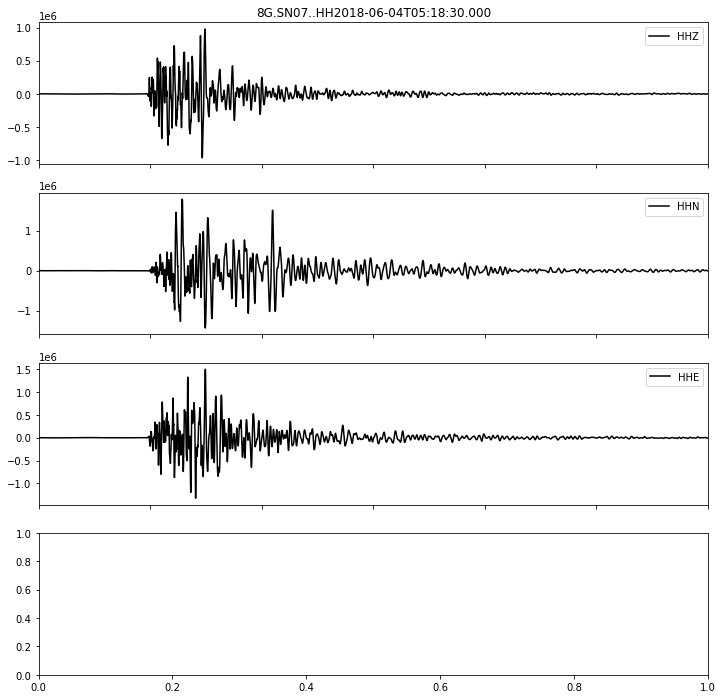

In [14]:
plt.figure(figsize=(12, 12))

ax1 = plt.subplot(411)
ax1.plot(data[:,2], 'k', label="HHZ")
ax1.legend()
ax1.set_xlim(0,len(data))
ax1.set_xticklabels([])
ax1.set_title(str(data_id)+str(timestamp))

ax2 = plt.subplot(412)
ax2.plot(data[:,1], 'k', label="HHN")
ax2.legend()
ax2.set_xlim(0,len(data))
ax2.set_xticklabels([])

ax3 = plt.subplot(413)
ax3.plot(data[:,0], 'k', label="HHE")
ax3.legend()
ax3.set_xlim(0,len(data))
ax3.set_xticklabels([])

ax4 = plt.subplot(414)
ax4.plot(preds[0, :, 0, 1], label="P")
ax4.plot(preds[0, :, 0, 2], label="S")
ax4.set_xlim(0,len(data))
ax4.set_ylim(0, 1)
ax4.set_ylabel('Probability')
ax4.legend()
df = event[0].stats.sampling_rate
ax4.set_xticks(np.arange(0, len(data), df*10), np.arange(0, len(data), df*10)/df)
ax4.set_xlabel('Time (s)')

plt.show()

We can do the same for SN14 for comparison

Picks [{'id': '8G.SN14..HH', 'timestamp': '2018-06-04T05:18:39.090', 'prob': 0.9752315282821655, 'amp': 135086.0, 'type': 'p'}, {'id': '8G.SN14..HH', 'timestamp': '2018-06-04T05:18:39.960', 'prob': 0.8347711563110352, 'amp': 135086.0, 'type': 's'}]


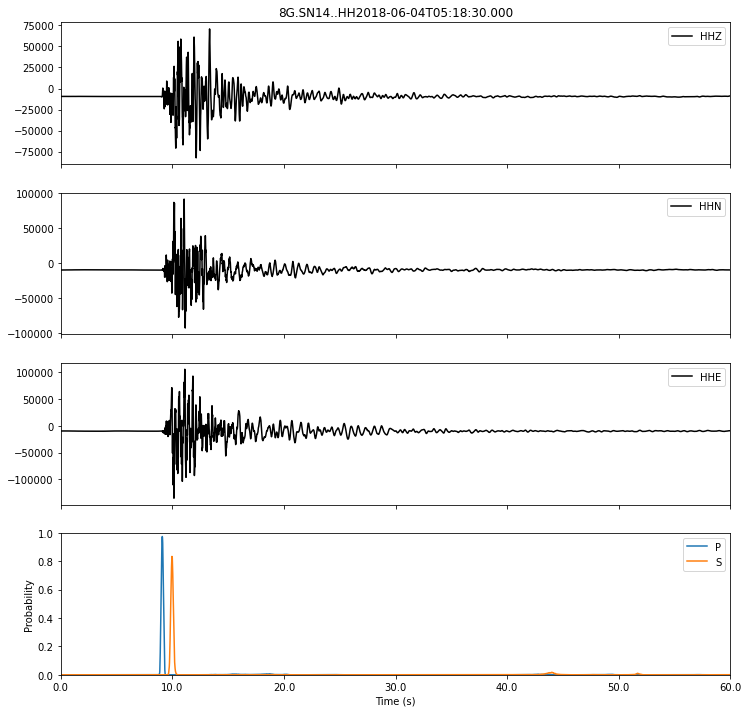

In [34]:
# Create the req input
stream = events[1].sort() # SN14 this time
data = []
for trace in stream:
    data.append(trace.data)
data = np.array(data).T
assert(data.shape[-1] == 3)
data_id = stream[0].get_id()[:-1]
timestamp = stream[0].stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]
req = {"id": [data_id],
       "timestamp": [timestamp],
       "vec": [data.tolist()]}

# Pass to QuakeFlow API
resp = requests.post(f'{PHASENET_API_URL}/predict_prob', json=req)
picks, preds = resp.json() 
preds = np.array(preds)
print('Picks', picks)

# Plot
plt.figure(figsize=(12, 12))

ax1 = plt.subplot(411)
ax1.plot(data[:,2], 'k', label="HHZ")
ax1.legend()
ax1.set_xlim(0,len(data))
ax1.set_xticklabels([])
ax1.set_title(str(data_id)+str(timestamp))

ax2 = plt.subplot(412)
ax2.plot(data[:,1], 'k', label="HHN")
ax2.legend()
ax2.set_xlim(0,len(data))
ax2.set_xticklabels([])

ax3 = plt.subplot(413)
ax3.plot(data[:,0], 'k', label="HHE")
ax3.legend()
ax3.set_xlim(0,len(data))
ax3.set_xticklabels([])

ax4 = plt.subplot(414)
ax4.plot(preds[0, :, 0, 1], label="P")
ax4.plot(preds[0, :, 0, 2], label="S")
ax4.set_xlim(0,len(data))
ax4.set_ylim(0, 1)
ax4.set_ylabel('Probability')
ax4.legend()
df = event[0].stats.sampling_rate
ax4.set_xticks(np.arange(0, len(data), df*10), np.arange(0, len(data), df*10)/df)
ax4.set_xlabel('Time (s)')

plt.show()

## 3) Running larger jobs in terminal

We can execute the predict function through the terminal to handle larger datasets. In the first instance we can just run the full 24hrs on 4th June 2018. 

There is another script provided in the PhaseNet repository `phasenet/test_data/prepare_mseed.ipynb` which walks you through the data download process and ensures files are in the correct directory structure and with the correct file names. 

The PhaseNet functions take in data input as numpy, mseed or hdf5 file formats. The predict function, has the following parameter requirements:


```
usage: predict.py [-h] [--batch_size BATCH_SIZE] [--model_dir MODEL_DIR]
                  [--data_dir DATA_DIR] [--data_list DATA_LIST]
                  [--hdf5_file HDF5_FILE] [--hdf5_group HDF5_GROUP]
                  [--result_dir RESULT_DIR] [--result_fname RESULT_FNAME]
                  [--min_p_prob MIN_P_PROB] [--min_s_prob MIN_S_PROB]
                  [--mpd MPD] [--amplitude] [--format FORMAT]
                  [--s3_url S3_URL] [--stations STATIONS] [--plot_figure]
                  [--save_prob]

optional arguments:
  -h, --help            show this help message and exit
  --batch_size BATCH_SIZE
                        batch size
  --model_dir MODEL_DIR
                        Checkpoint directory (default: None)
  --data_dir DATA_DIR   Input file directory
  --data_list DATA_LIST
                        Input csv file
  --hdf5_file HDF5_FILE
                        Input hdf5 file
  --hdf5_group HDF5_GROUP
                        data group name in hdf5 file
  --result_dir RESULT_DIR
                        Output directory
  --result_fname RESULT_FNAME
                        Output file
  --min_p_prob MIN_P_PROB
                        Probability threshold for P pick
  --min_s_prob MIN_S_PROB
                        Probability threshold for S pick
  --mpd MPD             Minimum peak distance
  --amplitude           if return amplitude value
  --format FORMAT       input format
  --s3_url S3_URL       s3 url
  --stations STATIONS   seismic station info
  --plot_figure         If plot figure for test
  --save_prob           If save result for test
```

We will use the pre-trained model in the PhaseNet repository. We can either run predict for just one station using `--format=mseed` 

~~~bash
python phasenet/predict.py --model=model/190703-214543 --data_list=demo/mseed/mseed.csv --data_dir=demo/mseed/waveforms/ --format=mseed
~~~

or for a whole network using `--format=mseed_array`

~~~bash
python phasenet/predict.py --model=model/190703-214543 --data_list=demo/mseed/mseed.csv --data_dir=demo/mseed/waveforms/mseed_array --stations=demo/stations.csv  --format=mseed_array --plot_figure
~~~

We can take a look at these input files:

In [1]:
!cat mseed/mseed.csv

fname
2018-06-04T00:00.mseed


In [2]:
!cat mseed/mseed_station.csv

fname
8G.SN04.2018-06-04T00:00.mseed
8G.SN05.2018-06-04T00:00.mseed
8G.SN07.2018-06-04T00:00.mseed
8G.SN11.2018-06-04T00:00.mseed
8G.SN12.2018-06-04T00:00.mseed
8G.SN13.2018-06-04T00:00.mseed
8G.SN14.2018-06-04T00:00.mseed


In [3]:
!cat stations.csv

station	x(km)	y(km)	z(km)	lat	lng	elv(m)	unit	component	response
8G.SN01..HH	60.235	53.153	-0.884	-0.837	-91.091	884.000	m/s	E,N,Z	248732000.00,249122000.00,249430000.00
8G.SN03..HH	60.377	60.124	-0.707	-0.774	-91.090	707.000	m/s	E,N,Z	2962220000.00,2969240000.00,2946990000.00
8G.SN04..HH	56.019	51.698	-1.073	-0.850	-91.129	1073.000	m/s	E,N,Z	2599400000.00,2564250000.00,2614120000.00
8G.SN05..HH	53.978	51.490	-1.045	-0.852	-91.148	1045.000	m/s	E,N,Z	2768020000.00,2741120000.00,2740730000.00
8G.SN07..HH	51.478	56.466	-1.067	-0.807	-91.170	1067.000	m/s	E,N,Z	2753300000.00,2753170000.00,2757670000.00
8G.SN08..HH	48.970	51.395	-0.661	-0.853	-91.193	661.000	m/s	E,N,Z	2757880000.00,2742610000.00,2761960000.00
8G.SN11..HH	56.599	57.043	-0.935	-0.802	-91.124	935.000	m/s	E,N,Z	2855490000.00,2845270000.00,2853690000.00
8G.SN12..HH	55.380	56.021	-0.957	-0.811	-91.135	957.000	m/s	E,N,Z	2805690000.00,2833360000.00,2817160000.00
8G.SN13..HH	62.059	77.315	-0.010	-0.620	-91.075	10.000	m/s	E,N,Z	285813

Let's examine the output from `mseed_array` for 4th June 2018. 

In [16]:
picks_csv = pd.read_csv("../results/picks.csv", sep="\t")
picks_csv.loc[:, 'p_idx'] = picks_csv["p_idx"].apply(lambda x: x.strip("[]").split(","))
picks_csv.loc[:, 'p_prob'] = picks_csv["p_prob"].apply(lambda x: x.strip("[]").split(","))
picks_csv.loc[:, 's_idx'] = picks_csv["s_idx"].apply(lambda x: x.strip("[]").split(","))
picks_csv.loc[:, 's_prob'] = picks_csv["s_prob"].apply(lambda x: x.strip("[]").split(","))

In [17]:
picks_csv

,fname,t0,p_idx,p_prob,s_idx,s_prob,p_amp,s_amp
0,8G.SN04..HH,2018-06-04T00:00:00.000,"[69238, 99672, 166355, 228015, 458393, 476731,...","[0.456, 0.747, 0.436, 0.977, 0.914, 0.621, 0.9...","[17939, 69602, 99698, 166480, 228066, 395832, ...","[0.778, 0.303, 0.784, 0.622, 0.785, 0.467, 0.7...","[7.678e-16,1.061e-15,8.050e-16,3.402e-15,1.405...","[1.318e-15,7.678e-16,1.061e-15,8.050e-16,3.402..."
1,8G.SN05..HH,2018-06-04T00:00:00.000,"[17918, 68894, 123919, 128153, 152431, 192775,...","[0.818, 0.815, 0.589, 0.940, 0.445, 0.910, 0.7...","[17991, 69211, 128227, 192847, 228122, 253434,...","[0.538, 0.731, 0.764, 0.765, 0.528, 0.363, 0.6...","[7.140e-16,8.385e-16,5.786e-16,1.686e-15,6.819...","[7.140e-16,8.385e-16,1.686e-15,5.984e-16,4.650..."
2,8G.SN07..HH,2018-06-04T00:00:00.000,"[68952, 92840, 139199, 155120, 160214, 166295,...","[0.524, 0.409, 0.843, 0.503, 0.808, 0.966, 0.5...","[38712, 69296, 92879, 139358, 155177, 166389, ...","[0.323, 0.571, 0.758, 0.602, 0.778, 0.864, 0.8...","[8.146e-16,1.019e-15,3.286e-16,8.486e-16,7.471...","[4.515e-16,8.146e-16,1.019e-15,3.286e-16,8.486..."
3,8G.SN11..HH,2018-06-04T00:00:00.000,"[151490, 166247, 264168, 327787, 335771, 39572...","[0.919, 0.969, 0.552, 0.936, 0.965, 0.938, 0.9...","[166317, 327850, 335869, 395841, 458396, 71861...","[0.723, 0.620, 0.803, 0.684, 0.873, 0.360, 0.6...","[5.319e-16,1.021e-15,4.394e-16,6.577e-16,5.900...","[1.021e-15,5.097e-16,5.900e-16,5.326e-16,2.120..."
4,8G.SN12..HH,2018-06-04T00:00:00.000,"[166247, 228119, 327802, 335806, 458339, 55453...","[0.975, 0.775, 0.901, 0.650, 0.947, 0.654, 0.9...","[166335, 228314, 327866, 335919, 458479, 55471...","[0.614, 0.360, 0.547, 0.504, 0.795, 0.405, 0.5...","[1.316e-15,7.299e-16,8.655e-16,6.715e-16,9.564...","[1.281e-15,6.196e-16,5.247e-16,5.224e-16,9.564..."
5,8G.SN13..HH,2018-06-04T00:00:00.000,"[48596, 50218, 55632, 65956, 73026, 232728, 29...","[0.414, 0.704, 0.351, 0.439, 0.510, 0.341, 0.4...","[9264, 10875, 12426, 48955, 50520, 56153, 6636...","[0.522, 0.644, 0.328, 0.495, 0.479, 0.745, 0.5...","[5.154e-16,4.125e-16,6.385e-16,4.629e-16,6.463...","[4.470e-16,3.213e-16,4.095e-16,5.116e-16,3.592..."
6,8G.SN14..HH,2018-06-04T00:00:00.000,"[68882, 123963, 128147, 166331, 192767, 227966...","[0.604, 0.918, 0.962, 0.783, 0.785, 0.376, 0.9...","[69193, 99722, 124009, 128207, 166463, 192827,...","[0.651, 0.322, 0.441, 0.807, 0.711, 0.508, 0.4...","[6.759e-15,1.358e-14,1.491e-14,8.629e-15,5.865...","[6.759e-15,5.263e-15,1.176e-14,1.491e-14,8.629..."


In [18]:
for i in range(len(picks_csv["p_prob"])):
    print(len(picks_csv["p_prob"][i]), 'picks identified at', picks_csv["fname"][i])
    

427 picks identified at 8G.SN04..HH
299 picks identified at 8G.SN05..HH
199 picks identified at 8G.SN07..HH
267 picks identified at 8G.SN11..HH
279 picks identified at 8G.SN12..HH
125 picks identified at 8G.SN13..HH
343 picks identified at 8G.SN14..HH


I used the `--plot_figure` option, which automatically stores a figure of the waveform and P- and S- phase probability timeseries in the `./results/figures` directory


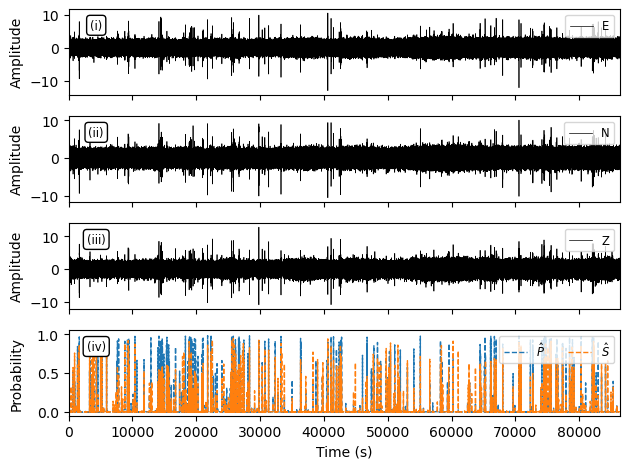

In [19]:
SN07_pprob = [float(i) for i in picks_csv["p_prob"][2]]
SN07_ploc = [float(i) for i in picks_csv["p_idx"][2]]
SN07_sprob = [float(i) for i in picks_csv["s_prob"][2]]
SN07_sloc = [float(i) for i in picks_csv["s_idx"][2]]

In [20]:
filt_ints = np.where(np.array(SN07_pprob)>0.9)
print(filt_ints)
print(len(filt_ints[0]), "P- phase picks at SN07 where prob > 0.9")

(array([  5,   9,  12,  16,  17,  18,  19,  20,  21,  22,  23,  27,  29,
        31,  32,  33,  34,  39,  49,  52,  55,  56,  58,  61,  62,  70,
        71,  72,  73,  74,  83,  84,  85,  86,  90,  92,  93,  94,  98,
       100, 101, 105, 106, 108, 109, 111, 112, 118, 119, 121, 123, 124,
       125, 128, 143, 145, 156, 158, 159, 161, 164, 167, 169, 170, 172,
       173, 174, 175, 176, 177, 178, 180, 185, 187, 189, 191, 192, 195]),)
78 P- phase picks at SN07 where prob > 0.9


In [35]:
for i in range(len(SN07_ploc)):
    print(i, '-', str(dt.timedelta(seconds=SN07_ploc[i]/100.)))

0 - 0:11:29.520000
1 - 0:15:28.400000
2 - 0:23:11.990000
3 - 0:25:51.200000
4 - 0:26:42.140000
5 - 0:27:42.950000
6 - 0:54:39.560000
7 - 0:55:43.530000
8 - 1:01:12
9 - 1:03:11.670000
10 - 1:12:28.420000
11 - 1:16:24.470000
12 - 1:23:31.990000
13 - 1:26:47.380000
14 - 1:39:03.670000
15 - 2:06:32.430000
16 - 2:07:25.030000
17 - 2:10:29.820000
18 - 2:26:44.910000
19 - 2:33:31.180000
20 - 2:35:19.540000
21 - 2:36:30.100000
22 - 2:37:01.950000
23 - 2:53:11.600000
24 - 2:58:14.700000
25 - 3:16:50.190000
26 - 3:17:31.560000
27 - 3:34:46.150000
28 - 3:53:13.190000
29 - 3:55:49.930000
30 - 3:56:44.670000
31 - 3:59:40.500000
32 - 4:00:40.430000
33 - 4:01:46.300000
34 - 4:04:22.170000
35 - 4:04:51.500000
36 - 4:06:04.420000
37 - 4:08:43.660000
38 - 4:15:34.910000
39 - 4:16:37.180000
40 - 4:16:45.310000
41 - 4:20:27.550000
42 - 4:21:15.690000
43 - 4:22:59.130000
44 - 4:27:58.370000
45 - 4:34:13.510000
46 - 4:39:09.470000
47 - 4:49:45.740000
48 - 5:00:42.910000
49 - 5:04:58.020000
50 - 5:11:06.9000

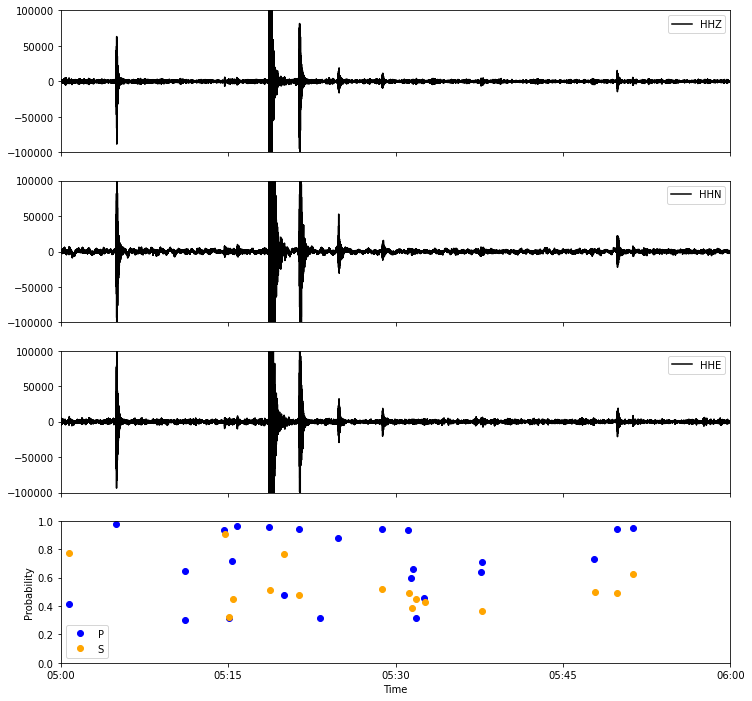

In [56]:
df = 100.
x1 = 5.*60.*60.*df
x2 = 6.*60.*60.*df #Plot between 5am and 6am
ymax = 1e5

# Plot
plt.figure(figsize=(12, 12))

ax1 = plt.subplot(411)
ax1.plot(st_store[0][2].data, 'k', label="HHZ")
ax1.legend()
ax1.set_xlim(x1,x2)
ax1.set_xticks(np.arange(x1, x2+1, df*60*15), [])
ax1.set_ylim(-ymax, ymax)

ax2 = plt.subplot(412)
ax2.plot(st_store[0][1].data, 'k', label="HHN")
ax2.legend()
ax2.set_xlim(x1,x2)
ax2.set_xticks(np.arange(x1, x2+1, df*60*15), [])
ax2.set_ylim(-ymax, ymax)

ax3 = plt.subplot(413)
ax3.plot(st_store[0][0].data, 'k', label="HHE")
ax3.legend()
ax3.set_xlim(x1,x2)
ax3.set_xticks(np.arange(x1, x2+1, df*60*15), [])
ax3.set_ylim(-ymax, ymax)

ax4 = plt.subplot(414)
ax4.plot(SN07_ploc, SN07_pprob, label="P", c='blue', marker='o', ls='')
ax4.plot(SN07_sloc, SN07_sprob, label="S", c='orange', marker='o', ls='')
ax4.set_xlim(x1,x2)
ax4.set_ylim(0, 1)
ax4.set_ylabel('Probability')
ax4.legend()
ax4.set_xticks(np.arange(x1, x2+1, df*60*15), ["05:00","05:15","05:30","05:45", "06:00"])
ax4.set_xlabel('Time')
plt.show()


A brute force cross-referencing approach?

In [58]:
SN14_pprob = [float(i) for i in picks_csv["p_prob"][6]]
SN14_ploc = [float(i) for i in picks_csv["p_idx"][6]]
SN14_sprob = [float(i) for i in picks_csv["s_prob"][6]]
SN14_sloc = [float(i) for i in picks_csv["s_idx"][6]]

In [63]:
SN14_ploc_filt = []
SN14_pprob_filt = []
SN07_ploc_filt = []
SN07_pprob_filt = []
for i in range(len(SN07_pprob)):
    for j in range(len(SN14_pprob)):
        diffs = SN14_ploc[j] - SN07_ploc[i]
        if diffs < 200. and SN07_pprob[i]> 0.9 and SN14_pprob[j]>0.9:
            SN14_ploc_filt.append(SN14_ploc[j])
            SN14_pprob_filt.append(SN14_pprob[j])
            SN07_ploc_filt.append(SN07_ploc[i])
            SN07_pprob_filt.append(SN07_pprob[i])
            print('Found a match (', len(SN14_ploc_filt), 'picks )')
            break
        else:
            pass
            
            

Found a match ( 1 picks )
Found a match ( 2 picks )
Found a match ( 3 picks )
Found a match ( 4 picks )
Found a match ( 5 picks )
Found a match ( 6 picks )
Found a match ( 7 picks )
Found a match ( 8 picks )
Found a match ( 9 picks )
Found a match ( 10 picks )
Found a match ( 11 picks )
Found a match ( 12 picks )
Found a match ( 13 picks )
Found a match ( 14 picks )
Found a match ( 15 picks )
Found a match ( 16 picks )
Found a match ( 17 picks )
Found a match ( 18 picks )
Found a match ( 19 picks )
Found a match ( 20 picks )
Found a match ( 21 picks )
Found a match ( 22 picks )
Found a match ( 23 picks )
Found a match ( 24 picks )
Found a match ( 25 picks )
Found a match ( 26 picks )
Found a match ( 27 picks )
Found a match ( 28 picks )
Found a match ( 29 picks )
Found a match ( 30 picks )
Found a match ( 31 picks )
Found a match ( 32 picks )
Found a match ( 33 picks )
Found a match ( 34 picks )
Found a match ( 35 picks )
Found a match ( 36 picks )
Found a match ( 37 picks )
Found a ma

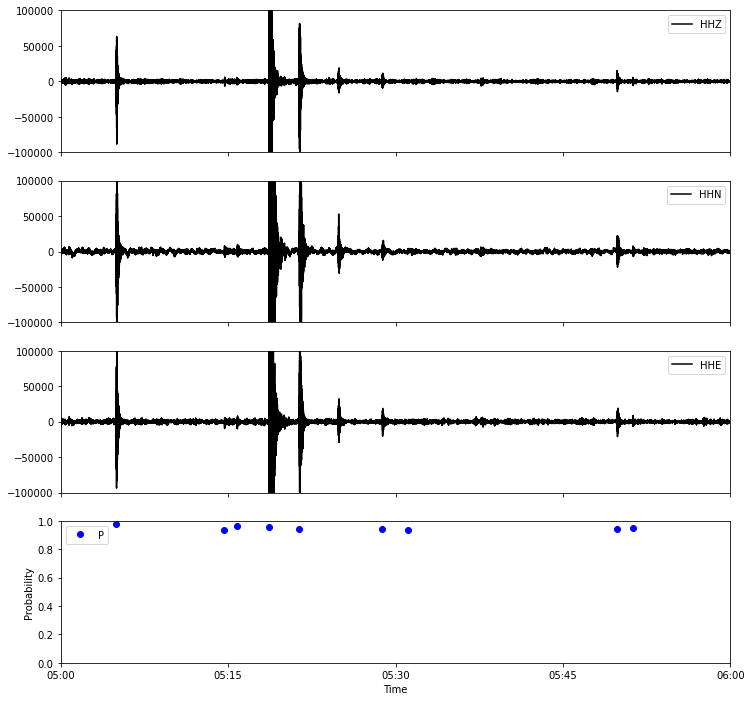

In [64]:
df = 100.
x1 = 5.*60.*60.*df
x2 = 6.*60.*60.*df #Plot between 5am and 6am
ymax = 1e5

# Plot
plt.figure(figsize=(12, 12))

ax1 = plt.subplot(411)
ax1.plot(st_store[0][2].data, 'k', label="HHZ")
ax1.legend()
ax1.set_xlim(x1,x2)
ax1.set_xticks(np.arange(x1, x2+1, df*60*15), [])
ax1.set_ylim(-ymax, ymax)

ax2 = plt.subplot(412)
ax2.plot(st_store[0][1].data, 'k', label="HHN")
ax2.legend()
ax2.set_xlim(x1,x2)
ax2.set_xticks(np.arange(x1, x2+1, df*60*15), [])
ax2.set_ylim(-ymax, ymax)

ax3 = plt.subplot(413)
ax3.plot(st_store[0][0].data, 'k', label="HHE")
ax3.legend()
ax3.set_xlim(x1,x2)
ax3.set_xticks(np.arange(x1, x2+1, df*60*15), [])
ax3.set_ylim(-ymax, ymax)

ax4 = plt.subplot(414)
ax4.plot(SN07_ploc_filt, SN07_pprob_filt, label="P", c='blue', marker='o', ls='')
ax4.set_xlim(x1,x2)
ax4.set_ylim(0, 1)
ax4.set_ylabel('Probability')
ax4.legend()
ax4.set_xticks(np.arange(x1, x2+1, df*60*15), ["05:00","05:15","05:30","05:45", "06:00"])
ax4.set_xlabel('Time')
plt.show()


## 4. Training a model

```bash
python phasenet/train.py  --model_dir=demo/training/ --train_dir=demo/mseed/waveforms --train_list=demo/mseed/mseed.csv  --plot_figure --epochs=10 --batch_size=10
```


In [57]:
!ls ./mseed/waveforms

2018-06-04T00:00.mseed         8G.SN11.2018-06-04T00:00.mseed
8G.SN04.2018-06-04T00:00.mseed 8G.SN12.2018-06-04T00:00.mseed
8G.SN05.2018-06-04T00:00.mseed 8G.SN13.2018-06-04T00:00.mseed
8G.SN07.2018-06-04T00:00.mseed 8G.SN14.2018-06-04T00:00.mseed
